In [1]:
import os
import numpy as np
import pandas as pd
import re
import pickle
import matplotlib.pyplot as plt

In [2]:
# path
cur_path = os.getcwd()
file_path = cur_path + "\Documents\\technical-assignment-2020-0823"
train_data_path = file_path + '\\test_data'

valid_data_path = file_path + '\\valid_data'
valid_label_path = file_path + '\\valid_label'

In [3]:
# read train data
valid_data = pd.read_csv(valid_data_path, sep='\n', names=["review"], header=None, skip_blank_lines=False)
valid_label = pd.read_csv(valid_label_path, sep='\n', names=["rate"], header=None)

In [4]:
valid = pd.concat([valid_data, valid_label], axis=1)

In [5]:
# drop invalid data
valid.drop_duplicates(subset=['review'], inplace=True)

# replace all other string to blank except korean
valid['review'] = valid['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
valid['review'].replace('', np.nan, inplace=True)
valid = valid.dropna(how = 'any')

print('전처리 후 샘플의 개수 :',len(valid))

전처리 후 샘플의 개수 : 9280


<AxesSubplot:>

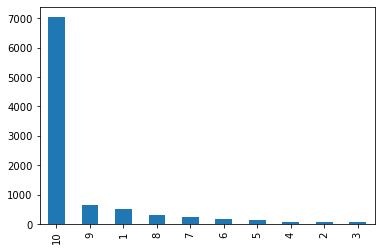

In [6]:
valid['rate'].value_counts().plot(kind = 'bar')

In [7]:
from konlpy.tag import Okt
okt = Okt()

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [8]:
# 토큰화 객체 계속 쓰기
X_valid = []
for sentence in valid['review']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_valid.append(temp_X)
print(len(X_valid))

9280


In [9]:
# 토큰화 객체 불러오기
with open('tokenized_data1.p', 'rb') as file:
    X_train = pickle.load(file)
    
with open('data1_label.p', 'rb') as file:
    y_train = pickle.load(file)
    
print(len(X_train))
print(len(y_train))

84222
84222


In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29531
등장 빈도가 2번 이하인 희귀 단어의 수: 17187
단어 집합에서 희귀 단어의 비율: 58.19985777657377
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.3858058875623716


In [11]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)

단어 집합의 크기 : 12346


In [12]:
y_valid = np.array(valid['rate'])

In [13]:
X_train = pad_sequences(X_train, maxlen = 30)
X_valid = pad_sequences(X_valid, maxlen = 30)

In [14]:
drop_train = [index for index, rate in enumerate(y_train) if rate > 4 and rate < 9]
drop_valid = [index for index, rate in enumerate(y_valid) if rate > 4 and rate < 9]

# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
X_valid = np.delete(X_valid, drop_valid, axis=0)
y_valid = np.delete(y_valid, drop_valid, axis=0)
print(len(X_train),len(y_train))
print(len(X_valid),len(y_valid))

64379 64379
8419 8419


In [15]:
#데이터 수정

y_valid = np.array([0 if i < 5 else 1 for i in y_valid])

y_train = np.array([0 if i < 5 else 1 for i in y_train])


In [16]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [17]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [18]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [19]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc],  batch_size=60, validation_data=(X_valid, y_valid))

Train on 64379 samples, validate on 8419 samples
Epoch 1/15
64320/64379 [============================>.] - ETA: 0s - loss: 0.3083 - acc: 0.8682
Epoch 00001: val_acc improved from -inf to 0.94334, saving model to best_model.h5
64379/64379 [==============================] - 56s 868us/sample - loss: 0.3082 - acc: 0.8682 - val_loss: 0.1658 - val_acc: 0.9433
Epoch 2/15
64320/64379 [============================>.] - ETA: 0s - loss: 0.2525 - acc: 0.8954
Epoch 00002: val_acc improved from 0.94334 to 0.94988, saving model to best_model.h5
64379/64379 [==============================] - 55s 855us/sample - loss: 0.2526 - acc: 0.8954 - val_loss: 0.1357 - val_acc: 0.9499
Epoch 3/15
64320/64379 [============================>.] - ETA: 0s - loss: 0.2306 - acc: 0.9059
Epoch 00003: val_acc improved from 0.94988 to 0.95201, saving model to best_model.h5
64379/64379 [==============================] - 95s 1ms/sample - loss: 0.2306 - acc: 0.9059 - val_loss: 0.1356 - val_acc: 0.9520
Epoch 4/15
64320/64379 [==

In [20]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_train, y_train)[1]))

64379/64379 [==============================] - 60s 937us/sample - loss: 0.1737 - acc: 0.9347

 테스트 정확도: 0.9347
